# How to Train an Object Detection Model with Keras
### by Jason Brownlee

[Tutorial](https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/).

Note: Highly recommended to run training on an AWS EC2 Deep Learning AMI instance.

## Parse Annotation File

In [1]:
# example of extracting bounding boxes from an annotation file
from xml.etree import ElementTree

# function to extract bounding boxes from an annotation file
def extract_boxes(filename):
    # load and parse the file
    tree = ElementTree.parse(filename)
    # get the root of the document
    root = tree.getroot()
    # extract each bounding box
    boxes = list()
    for box in root.findall(".//bndbox"):
        xmin = int(box.find("xmin").text)
        ymin = int(box.find("ymin").text)
        xmax = int(box.find("xmax").text)
        ymax = int(box.find("ymax").text)
        coors = [xmin, ymin, xmax, ymax]
        boxes.append(coors)
    # extract image dimensions
    width = int(root.find(".//size/width").text)
    height = int(root.find(".//size/height").text)
    return boxes, width, height

# extract details form annotation file
boxes, w, h = extract_boxes("kangaroo/annots/00001.xml")
# summarize extracted details
print(boxes, w, h)

[[233, 89, 386, 262], [134, 105, 341, 253]] 450 319


## Develop KangarooDataset Object

In [3]:
# split into train and test set
from os import listdir
from xml.etree import ElementTree
from numpy import zeros, asarray
from mrcnn.utils import Dataset

# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class (we're only looking for kangaroos)
        self.add_class("dataset", 1, "kangaroo")
        # define data locations
        images_dir = dataset_dir + "/images/"
        annots_dir = dataset_dir + "/annots/"
        # find all images
        for filename in listdir(images_dir):
            # extract image id
            image_id = filename[:-4]
            # 00090 in kangaroo dataset is corrupt; skip it
            if image_id in ["00090"]:
                continue
            # Building train set? Skip images after 150
            if is_train and int(image_id) >= 150:
                continue
            # Building test/val set? Skip images before 150
            if not is_train and int(image_id) < 150:
                continue
            image_path = images_dir + filename
            annot_path = annots_dir + image_id + ".xml"
            # add to dataset
            self.add_image("dataset",
                           image_id=image_id,
                           path=image_path,
                           annotation=annot_path)
            
    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall(".//bndbox"):
            xmin = int(box.find("xmin").text)
            ymin = int(box.find("ymin").text)
            xmax = int(box.find("xmax").text)
            ymax = int(box.find("ymax").text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find(".//size/width").text)
        height = int(root.find(".//size/height").text)
        return boxes, width, height
    
    # load the masks for an image
    def load_masks(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info["annotation"]
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype="uint8")
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index("kangaroo"))
        return masks, asarray(class_ids, dtype="int32")
    
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info["path"]
    
# train set
train_set = KangarooDataset()
train_set.load_dataset("kangaroo", is_train=True)
train_set.prepare()
print("Train: %d" % len(train_set.image_ids))
# test/val set
test_set = KangarooDataset()
test_set.load_dataset("kangaroo", is_train=False)
test_set.prepare()
print("Test: %d" % len(test_set.image_ids))

Train: 131
Test: 32


## Test KangarooDataset Object

(626, 899, 3)
(626, 899, 1)


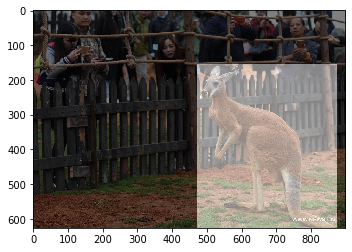

In [5]:
# plot one photograph and mask
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from matplotlib import pyplot

# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "kangaroo")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        # find all images
        for filename in listdir(images_dir):
            # extract image id
            image_id = filename[:-4]
            # skip bad images
            if image_id in ['00090']:
                continue
            # skip all images after 150 if we are building the train set
            if is_train and int(image_id) >= 150:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and int(image_id) < 150:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('kangaroo'))
        return masks, asarray(class_ids, dtype='int32')

    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# train set
train_set = KangarooDataset()
train_set.load_dataset('kangaroo', is_train=True)
train_set.prepare()
# load an image
image_id = 0
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
pyplot.show()

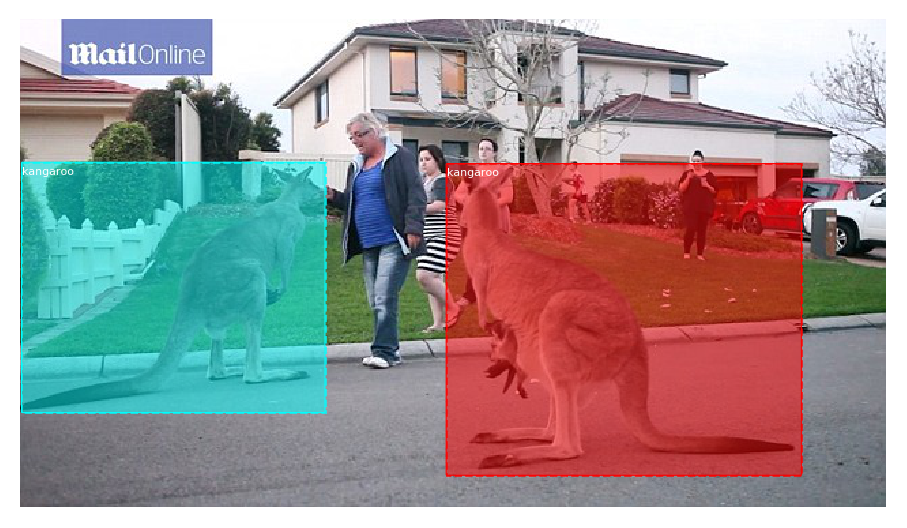

In [6]:
# display image with masks and bounding boxes
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "kangaroo")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        # find all images
        for filename in listdir(images_dir):
            # extract image id
            image_id = filename[:-4]
            # skip bad images
            if image_id in ['00090']:
                continue
            # skip all images after 150 if we are building the train set
            if is_train and int(image_id) >= 150:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and int(image_id) < 150:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('kangaroo'))
        return masks, asarray(class_ids, dtype='int32')

    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# train set
train_set = KangarooDataset()
train_set.load_dataset('kangaroo', is_train=True)
train_set.prepare()
# define image id
image_id = 1
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

## How to Train Mask R-CNN Model for Kangaroo Detection

In [ ]:
# fit a mask rcnn on the kangaroo dataset
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "kangaroo")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        # find all images
        for filename in listdir(images_dir):
            # extract image id
            image_id = filename[:-4]
            # skip bad images
            if image_id in ['00090']:
                continue
            # skip all images after 150 if we are building the train set
            if is_train and int(image_id) >= 150:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and int(image_id) < 150:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('kangaroo'))
        return masks, asarray(class_ids, dtype='int32')

    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# define a configuration for the model
class KangarooConfig(Config):
    # define the name of the configuration
    NAME = "kangaroo_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # number of training steps per epoch
    STEPS_PER_EPOCH = 131

# prepare train set
train_set = KangarooDataset()
train_set.load_dataset('kangaroo', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = KangarooDataset()
test_set.load_dataset('kangaroo', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# prepare config
config = KangarooConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')

A model file is created and saved at the end of each epoch in a subdirectory that starts with "kangaroo_cfg" followed by random characters.

A model must be selected for use; in this case, the loss continues to decrease for the bounding boxes on each epoch, so we will use the final model at the end of the run ("mask_rcnn_kangaroo_cfg_0005.h5").

Copy the model file from the config directory into your current working directory. We will use it in the following sections to evaluate the model and make predictions.

## How to Evaluate a Mask R-CNN Model

In [ ]:
# evaluate the mask rcnn model on the kangaroo dataset
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "kangaroo")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        # find all images
        for filename in listdir(images_dir):
            # extract image id
            image_id = filename[:-4]
            # skip bad images
            if image_id in ['00090']:
                continue
            # skip all images after 150 if we are building the train set
            if is_train and int(image_id) >= 150:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and int(image_id) < 150:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('kangaroo'))
        return masks, asarray(class_ids, dtype='int32')

    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "kangaroo_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP

# load the train dataset
train_set = KangarooDataset()
train_set.load_dataset('kangaroo', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# load the test dataset
test_set = KangarooDataset()
test_set.load_dataset('kangaroo', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights('mask_rcnn_kangaroo_cfg_0005.h5', by_name=True)
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

## How to Detect Kangaroos in New Photos

In [ ]:
# detect kangaroos in photos with mask rcnn model
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.utils import Dataset

# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "kangaroo")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        # find all images
        for filename in listdir(images_dir):
            # extract image id
            image_id = filename[:-4]
            # skip bad images
            if image_id in ['00090']:
                continue
            # skip all images after 150 if we are building the train set
            if is_train and int(image_id) >= 150:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and int(image_id) < 150:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # load all bounding boxes for an image
    def extract_boxes(self, filename):
        # load and parse the file
        root = ElementTree.parse(filename)
        boxes = list()
        # extract each bounding box
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('kangaroo'))
        return masks, asarray(class_ids, dtype='int32')

    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "kangaroo_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
    # load image and mask
    for i in range(n_images):
        # load the image and mask
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        pyplot.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Actual')
        # plot masks
        for j in range(mask.shape[2]):
            pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        # get the context for drawing boxes
        pyplot.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Predicted')
        ax = pyplot.gca()
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
    # show the figure
    pyplot.show()

# load the train dataset
train_set = KangarooDataset()
train_set.load_dataset('kangaroo', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# load the test dataset
test_set = KangarooDataset()
test_set.load_dataset('kangaroo', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model_path = 'mask_rcnn_kangaroo_cfg_0005.h5'
model.load_weights(model_path, by_name=True)
# plot predictions for train dataset
plot_actual_vs_predicted(train_set, model, cfg)
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg)